# Schelling Segregation Model

## Implementation

 Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

In [1]:
import matplotlib.pyplot as plt
import mesa
import pandas as pd
%matplotlib inline

from model2 import Schelling

Now we instantiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 30% similar neighbors.

In [2]:
model = Schelling(30, 30, 0.8, 0.3, 0.3)

This is model 2


C:\Users\anned\OneDrive\Documenten\anne\CUSP\Python models\SchellingSegregation-main\venv\lib\site-packages\mesa\space.py:213: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 200 steps or until it stops on its own, whichever comes first:

In [3]:
while model.running and model.schedule.steps < 200:
    model.step()

print(model.schedule.steps) # Show how many steps have actually run

True 6
6


In [4]:
print(model.schedule.get_agent_count())

718


In [5]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,happy,total_satisfaction_index,blue_satisfaction_index,red_satisfaction_index,segregated_Agents,happiness reached,time
0,0,0.000000,0.000000,0.000000,0.052925,False,0
1,592,0.824513,0.574468,0.946170,0.225627,False,1
2,685,0.954039,0.885106,0.987578,0.330084,False,2
3,707,0.984680,0.978723,0.987578,0.360724,False,3
4,715,0.995822,0.991489,0.997930,0.370474,False,4
5,717,0.998607,0.995745,1.000000,0.371866,False,5
6,718,1.000000,1.000000,1.000000,0.371866,True,6


The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [6]:
model_out = model.datacollector.get_model_vars_dataframe()

In [7]:
model_out.sort_values('happy', ascending=False)

,happy,total_satisfaction_index,blue_satisfaction_index,red_satisfaction_index,segregated_Agents,happiness reached,time
6,718,1.000000,1.000000,1.000000,0.371866,True,6
5,717,0.998607,0.995745,1.000000,0.371866,False,5
4,715,0.995822,0.991489,0.997930,0.370474,False,4
3,707,0.984680,0.978723,0.987578,0.360724,False,3
2,685,0.954039,0.885106,0.987578,0.330084,False,2
1,592,0.824513,0.574468,0.946170,0.225627,False,1
0,0,0.000000,0.000000,0.000000,0.052925,False,0


Finally, we can plot the 'happy' series:

<Axes: >

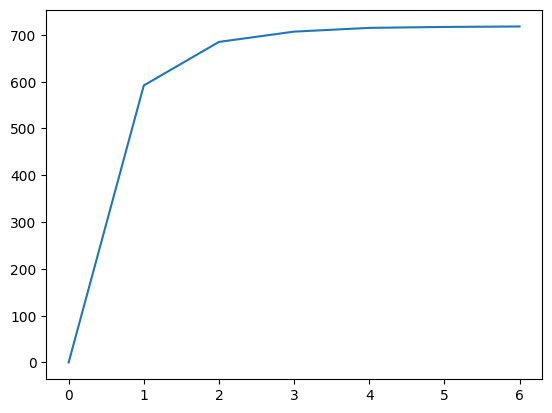

In [8]:
model_out.happy.plot()

# Batchrunner: Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [9]:
import numpy as np
parameters = {"height": 10, "width": 10, "density": 0.8, "minority_pc": 0.2,
              "homophily": np.arange(0.0, 1.0, 0.1)}

In [10]:
from mesa import batch_run
param_sweep = batch_run(Schelling,parameters, iterations=10, max_steps=100)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\anned\OneDrive\Documenten\anne\CUSP\Python models\SchellingSegregation-main\venv\lib\site-packages\mesa\space.py:213: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


This is model 2
True 1
This is model 2
True 3
This is model 2
True 3
This is model 2
False 4
This is model 2
False 4
This is model 2
False 4
This is model 2
False 4
This is model 2


 21%|██        | 21/100 [00:00<00:01, 53.79it/s]

This is model 2
False 2
This is model 2
False 2
This is model 2
True 1
This is model 2
True 2
This is model 2
True 3
This is model 2
True 3
This is model 2
False 3
This is model 2
False 6
This is model 2
False 2
This is model 2
False 6
This is model 2
False 3
This is model 2
False 2
This is model 2
True 1
This is model 2
True 2
This is model 2
True 5
This is model 2
False 3
This is model 2
False 4
This is model 2
True 6
This is model 2
True 8
This is model 2
False 7
This is model 2


 41%|████      | 41/100 [00:00<00:00, 71.23it/s]

False 7
This is model 2
False 2
This is model 2
True 1
This is model 2
True 2
This is model 2
False 3
This is model 2
True 3
This is model 2
False 3
This is model 2
False 2
This is model 2
False 8
This is model 2
False 6
This is model 2
False 3
This is model 2
False 2
This is model 2
True 1
This is model 2
True 3
This is model 2
True 4
This is model 2
False 3
This is model 2
False 1
This is model 2
False 8
This is model 2
False 8
This is model 2
False 6
This is model 2
False 5
This is model 2
False 2


 50%|█████     | 50/100 [00:00<00:00, 73.14it/s]

This is model 2
True 1
This is model 2
True 2
This is model 2
True 2
This is model 2
True 3
This is model 2
False 3
This is model 2
False 5
This is model 2
False 7
This is model 2


 71%|███████   | 71/100 [00:01<00:00, 65.43it/s]

This is model 2
False 2
This is model 2
False 2
This is model 2
True 1
This is model 2
True 4
This is model 2
False 4
This is model 2
False 3
This is model 2
False 2
This is model 2
False 4
This is model 2
False 9
This is model 2
False 13
This is model 2
False 2
This is model 2
False 2
This is model 2
True 1
This is model 2
True 4
This is model 2
True 3
This is model 2
True 5
This is model 2
False 6
This is model 2
True 8
This is model 2
False 8
This is model 2
False 6
This is model 2
False 3
This is model 2
False 2
This is model 2
True 1
This is model 2
True 3


100%|██████████| 100/100 [00:01<00:00, 69.25it/s]

This is model 2
True 3
This is model 2
False 3
This is model 2
False 4
This is model 2
True 3
This is model 2
False 5
This is model 2
False 5
This is model 2
True 11
This is model 2
False 2
This is model 2
True 1
This is model 2
True 2
This is model 2
True 3
This is model 2
False 3
This is model 2
False 2
This is model 2
False 5
This is model 2
False 5
This is model 2
False 6
This is model 2
False 2
This is model 2
False 2


In [11]:
import pandas as pd
df = pd.DataFrame.from_dict(param_sweep)

In [12]:
df

,RunId,iteration,Step,height,width,density,minority_pc,homophily,happy,total_satisfaction_index,blue_satisfaction_index,red_satisfaction_index,segregated_Agents,happiness reached,time
0,0,0,0,10,10,0.8,0.2,0.0,0,0.000000,0.000000,0.000000,0.024390,False,0
1,1,0,2,10,10,0.8,0.2,0.1,81,0.987805,0.916667,1.000000,0.280488,False,2
2,2,0,2,10,10,0.8,0.2,0.2,76,0.974359,0.882353,1.000000,0.282051,False,2
3,3,0,3,10,10,0.8,0.2,0.3,75,0.974026,0.882353,1.000000,0.376623,False,3
4,4,0,3,10,10,0.8,0.2,0.4,73,0.901235,0.529412,1.000000,0.209877,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,4,10,10,0.8,0.2,0.5,73,0.948052,0.714286,1.000000,0.467532,False,4
96,96,9,4,10,10,0.8,0.2,0.6,68,0.883117,0.529412,0.983333,0.441558,False,4
97,97,9,5,10,10,0.8,0.2,0.7,71,0.865854,0.473684,0.984127,0.475610,False,5
98,98,9,1,10,10,0.8,0.2,0.8,42,0.525000,0.000000,0.646154,0.325000,False,1


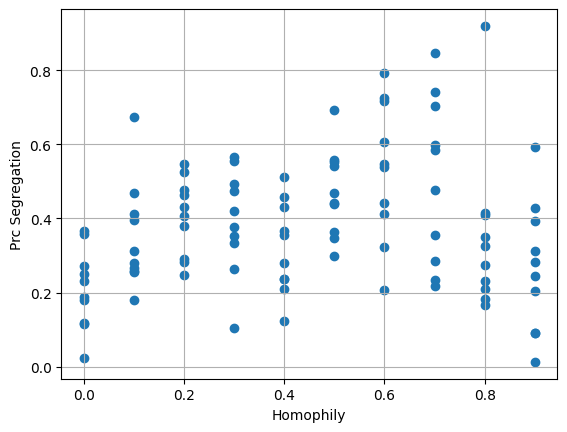

In [13]:
plt.scatter(df.homophily, df.segregated_Agents)
plt.xlabel('Homophily')
plt.ylabel('Prc Segregation')
plt.grid(True)

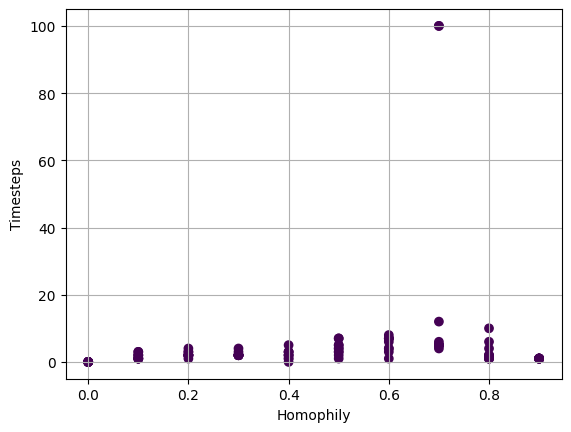

In [14]:
plt.scatter(df.homophily, df.Step, c = df['happiness reached'])
plt.xlabel('Homophily')
plt.ylabel('Timesteps')
plt.grid(True)